In [581]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
import scipy.signal as signal
import pywt

In [582]:
# Moon sample

# Get catalog
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

# Get all useful data from a catalog file
row = cat.iloc[7]

arrival_time_rel = row['time_rel(sec)']

data_directory = './data/lunar/training/data/S12_GradeA/'
data_file = f'{data_directory}{row.filename}.mseed'
data_cat = read(data_file)

# Read in time steps and velocities
times = data_cat.traces[0].times()
data = data_cat.traces[0].data
data += np.random.normal(0, 1, len(data)) * 1e-9


sample_rate = times[1] - times[0]
samples = data

In [583]:
# Earth sample
import os

arrival_time_rel = 3000

data_folder = './pyweed/'
data_file = data_folder + os.listdir(data_folder)[0]
data_cat = read(data_file)

# Read in time steps and velocities
times = data_cat.traces[0].times()
data = data_cat.traces[0].data

sample_rate = times[1] - times[0]
samples = data

In [584]:
# Mars sample
import os

# Get catalog
# cat_directory = './data/mars/test/catalogs/'
# cat_file = cat_directory + 'Mars_InSight_training_catalog_final.csv'
# cat = pd.read_csv(cat_file)

# # Get all useful data from a catalog file
# row = cat.iloc[1]

# arrival_time_rel = row['time_rel(sec)']
arrival_time_rel = 0

index = 4

data_directory = './data/mars/test/data/'
filename = list(filter(lambda x: x.endswith(".mseed"), os.listdir(data_directory)))[index]

data_file = f'{data_directory}{filename}'
data_cat = read(data_file)

# Read in time steps and velocities
times = data_cat.traces[0].times()
data = data_cat.traces[0].data

sample_rate = times[1] - times[0]
samples = data

In [585]:
# Functions and additional data

scales = np.arange(1, 150, 3)

def cwt_wavelet_transform(signal, sample_rate, wavelet='morl'):
    coef, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/sample_rate)
    return coef, freqs

def scale_to_frequency(scales, wavelet, sample_rate):
    frequencies = pywt.scale2frequency(wavelet, scales) * sample_rate
    return frequencies

In [586]:
# Calculations
coef, new_scales = cwt_wavelet_transform(samples, sample_rate)
frequencies = scale_to_frequency(new_scales, 'morl', sample_rate)

# Normalizing coefficients
coef = coef / np.max(np.abs(coef))

In [587]:
from scipy.signal import fftconvolve, convolve

# Filtering the wave
main_convolution = None
for i in range(1, 50):
    kernel_size = 300*i
    # kernel_size = 400*i
    # kernel_size = 100 + 10*1.115**i

    kernel = (np.cos(np.arange(kernel_size) * np.pi / kernel_size) + 1) / 2

    result = fftconvolve(np.abs(np.minimum(np.maximum(data, -500), 500)), kernel, mode="same") * i
    if main_convolution is None:
        main_convolution = result
    else:
        main_convolution += result

main_convolution = main_convolution / main_convolution.max()

# Approximating locations of events
temp_data = main_convolution


# def detect_events(convolution, sensitivity=2):
#     # Calculate mean and standard deviation of the main convolution
#     mu = np.mean(convolution)
#     sigma = np.std(convolution)
    
#     # Define dynamic threshold
#     threshold = mu + sensitivity * sigma
    
#     # Find peaks above the dynamic threshold
#     peaks, _ = find_peaks(convolution, height=threshold)
    
#     return peaks, threshold
mu = np.mean(main_convolution)
sigma = np.std(main_convolution)

# Define dynamic threshold
# event_detection_threshold = mu + 2 * sigma

# event_detection_threshold = 0.55
event_detection_threshold = np.sum(main_convolution) / len(main_convolution)
temp_data -= event_detection_threshold

def detect_positive_sign_change(data):
    data = np.sign(data)

    signal_start_kernel = np.array([-1., 1.])
    data = -convolve(data, signal_start_kernel, mode="same")

    indices = np.where(data == 2)
    return indices[0]

arrival_times_rel_predicted = detect_positive_sign_change(temp_data) * sample_rate

# Calculating actual event start times
event_start_max_error = 150
value_difference_peak_threshold = 1.5

kernel_size = 500
kernel = (np.cos(np.arange(kernel_size) * np.pi / kernel_size) + 1) / 2

precise_convolution = fftconvolve(data**2, kernel, mode="same")
d_precise_convolution = fftconvolve(precise_convolution, np.array([-1/45, 0.1, -0.3, 0.8, 0, -0.8, 0.3, -0.1, 1/45]), mode="same")
#  = detect_positive_sign_change(precise_convolution) * sample_rate

# indices = np.where(data - )

# arrival_time_rel_predicted = 0
# data = temp_data arrival_times_rel
arrival_times_rel_predicted


array([  88.05, 1472.25, 2692.6 ])

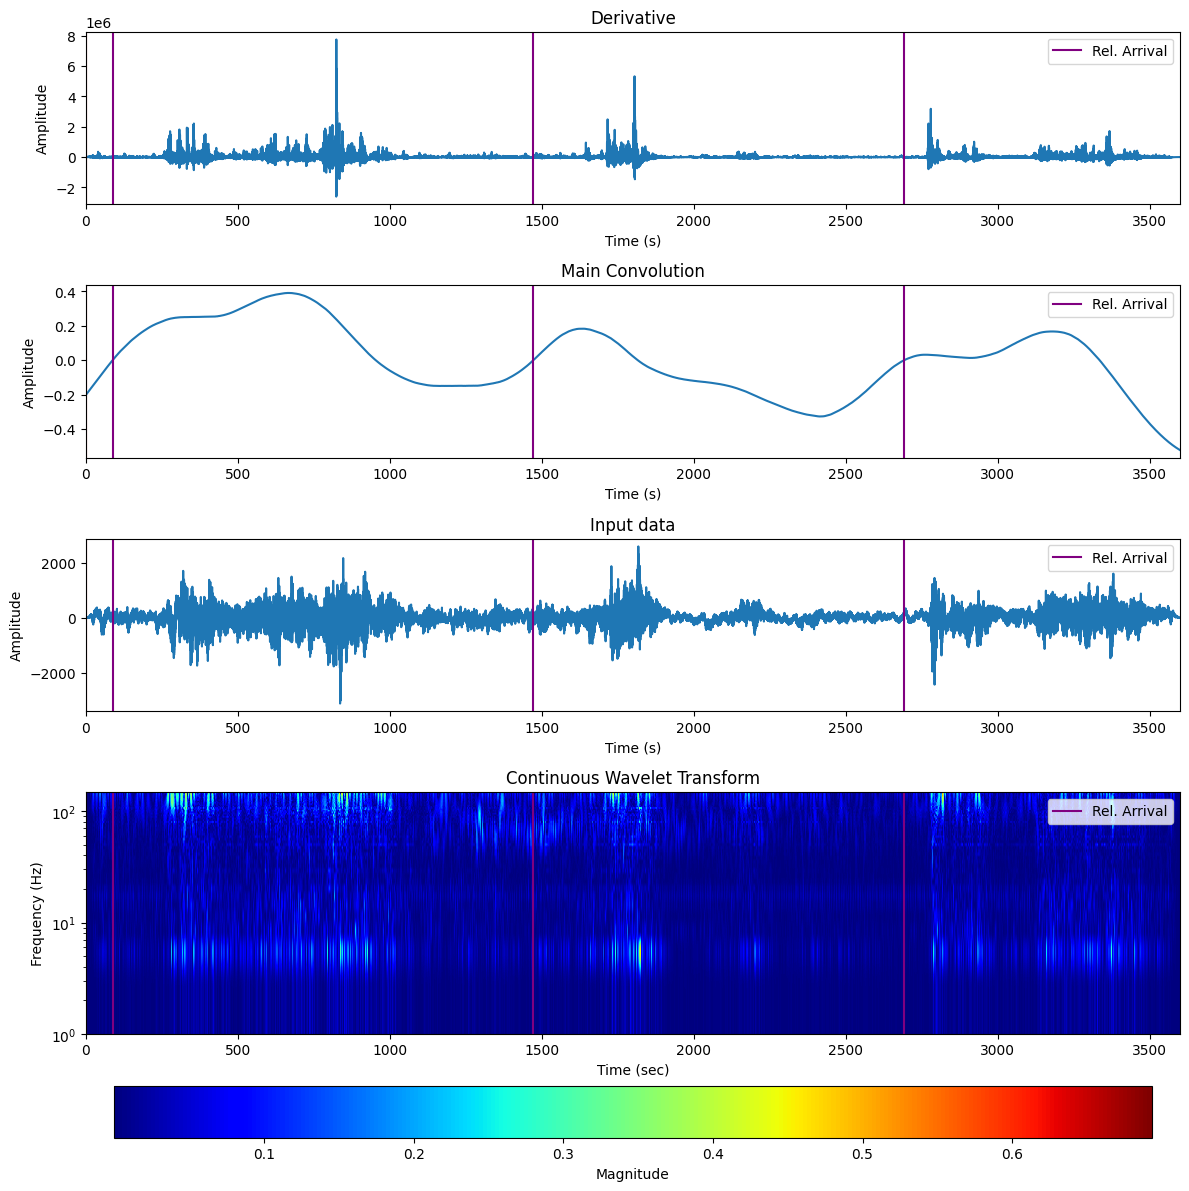

In [588]:
# Plotting the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 2]})

# Plot the input function
ax1.set_xlim(0, times.max())  # Set the x-axis limits
ax1.plot(times, d_precise_convolution)
ax1.set_title('Derivative')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot where the arrival time is
arrival_line = ax1.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax1.legend(handles=[arrival_line])
for t in arrival_times_rel_predicted:
    line = ax1.axvline(x=t, c='purple', label='Rel. Arrival')
    ax1.legend(handles=[line])

# Plot the second function (main convolution)
ax2.set_xlim(0, times.max())  # Set the x-axis limits
ax2.plot(times, main_convolution)
ax2.set_title('Main Convolution')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')

# Plot where the arrival time is
arrival_line = ax2.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax2.legend(handles=[arrival_line])
for t in arrival_times_rel_predicted:
    line = ax2.axvline(x=t, c='purple', label='Rel. Arrival')
    ax2.legend(handles=[line])

# Plot the third graph with somedata
ax3.set_xlim(0, times.max())  # Set the x-axis limits
ax3.plot(times, data)
ax3.set_title('Input data')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude')

# Plot where the arrival time is
arrival_line = ax3.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax3.legend(handles=[arrival_line])
for t in arrival_times_rel_predicted:
    line = ax3.axvline(x=t, c='purple', label='Rel. Arrival')
    ax3.legend(handles=[line])

# Plot the Continuous Wavelet Transform
im = ax4.imshow(np.log1p(np.abs(coef)), extent=[times.min(), times.max(), frequencies.min(), frequencies.max()],
            cmap='jet', aspect='auto', origin='lower')
ax4.set_ylabel('Frequency (Hz)')
ax4.set_xlabel('Time (sec)')
ax4.set_title('Continuous Wavelet Transform')
ax4.set_yscale('log')

# Plot where the arrival time is
arrival_line = ax4.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax4.legend(handles=[arrival_line])
for t in arrival_times_rel_predicted:
    line = ax4.axvline(x=t, c='purple', label='Rel. Arrival')
    ax4.legend(handles=[line])

# Add colorbar
cbar = fig.colorbar(im, ax=ax4, orientation='horizontal')
cbar.set_label('Magnitude')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
